In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
# Carregar a tabela de modelagem mais recente (com features de CMO, Disponibilidade, etc.)
# ATENÇÃO: Verifique se 'modeling_table_v2.parquet' é o nome do último arquivo que você salvou.
path_base = '../data/processed/modeling_table_v2.parquet'
df_base = pd.read_parquet(path_base)
print(f"Tabela base de modelagem carregada com {df_base.shape[0]} registros.")

# Carregar o novo arquivo de dados climáticos
try:
    path_clima = '../data/raw/clima_go_diario.csv'
    df_clima_raw = pd.read_csv(path_clima)
    print(f"Dados de meteorologia carregados com {len(df_clima_raw)} registros.")
except FileNotFoundError:
    print("ERRO: Arquivo 'clima_go_diario.csv' não encontrado.")
    print("Por favor, execute o script 'scripts/download_weather_data.py' primeiro.")
    raise

Tabela base de modelagem carregada com 2781 registros.
Dados de meteorologia carregados com 2842 registros.


In [3]:
# Faz uma cópia para segurança
df_clima = df_clima_raw.copy()

# Converte a coluna 'data' para o formato datetime e a define como índice
df_clima['timestamp'] = pd.to_datetime(df_clima['data'])
df_clima.set_index('timestamp', inplace=True)

# Seleciona apenas as colunas que nos interessam
df_clima = df_clima[['ghi', 'temp2m_c', 'precipitacao_mm']]

print("Dados de meteorologia processados.")
display(df_clima.head())

Dados de meteorologia processados.


,ghi,temp2m_c,precipitacao_mm
timestamp,,,
2018-01-01,6.387950,24.5300,2.3200
2018-01-02,4.562175,24.7375,8.2350
2018-01-03,5.708525,23.6250,5.0975
2018-01-04,5.635325,23.8500,8.5275
2018-01-05,4.365900,23.1875,14.2425


In [4]:
# Começa com a nossa tabela de modelagem
df_final = df_base.copy()

# Adiciona as novas features de meteorologia
df_final = df_final.join(df_clima)

print(f"Shape ANTES do tratamento de nulos: {df_final.shape}")
print(f"Valores nulos em 'ghi' ANTES: {df_final['ghi'].isnull().sum()}")

# Se houver alguma falha no download da API da NASA, preenchemos com o valor do dia anterior
df_final.ffill(inplace=True)
df_final.bfill(inplace=True) # Garante que o início também seja preenchido

print(f"\nShape DEPOIS do tratamento de nulos: {df_final.shape}")
print(f"Valores nulos em 'ghi' DEPOIS: {df_final['ghi'].isnull().sum()}")

print("\nTabela final enriquecida com dados de meteorologia:")
display(df_final.head())

Shape ANTES do tratamento de nulos: (2781, 25)
Valores nulos em 'ghi' ANTES: 0

Shape DEPOIS do tratamento de nulos: (2781, 25)
Valores nulos em 'ghi' DEPOIS: 0

Tabela final enriquecida com dados de meteorologia:


,deficit_diario_mwh,nivel_risco,programada,verificada,diferenca_verif_prog,geracao_total_diaria_go,geracao_fotovoltaica_diaria,geracao_hidroelétrica_diaria,geracao_térmica_diaria,total_mwh_restrito_go,...,geracao_media_7d,ear_ontem,ear_diff_3d,margem_oferta_demanda,pressao_demanda_ear,cmo_semanal_seco,disponibilidade_total_diaria_go,ghi,temp2m_c,precipitacao_mm
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-01-31,0.0,baixo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,30.939899,0.350500,0.0,0.0,172.05,68377.855334,4.760425,24.8575,6.5800
2018-02-01,0.0,baixo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,31.133301,0.565500,0.0,0.0,172.05,68693.764000,4.410400,25.1375,6.0425
2018-02-02,0.0,baixo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,31.369699,0.666601,0.0,0.0,157.33,70021.127168,4.893775,23.7450,5.2950
2018-02-03,0.0,baixo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,31.606501,0.781000,0.0,0.0,157.33,71659.675333,3.758825,23.5375,15.0100
2018-02-04,0.0,baixo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,31.914301,0.924200,0.0,0.0,157.33,71665.321333,3.604200,22.6800,20.5150


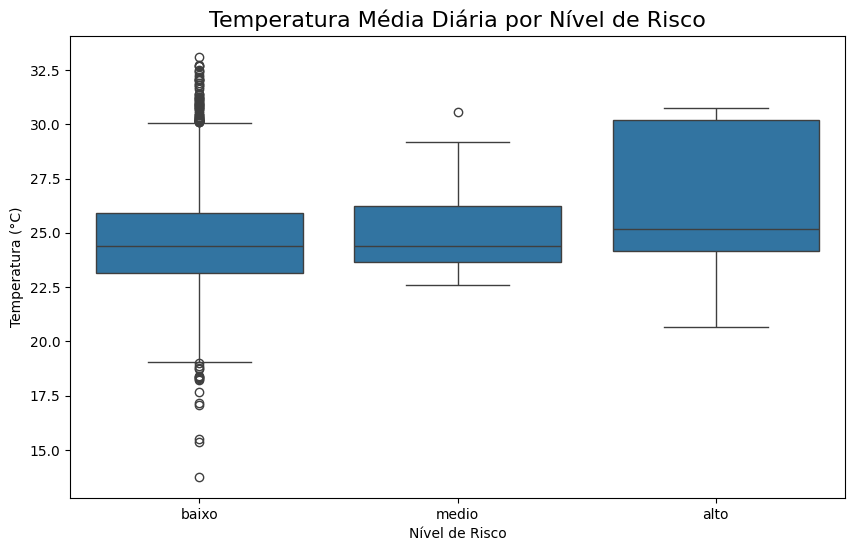

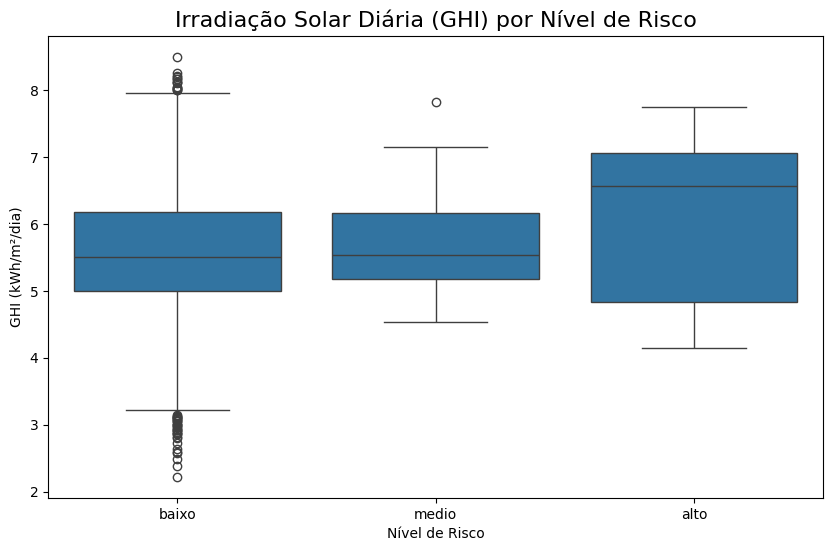

In [5]:
# Gráfico 1: Temperatura Média por Nível de Risco
plt.figure(figsize=(10, 6))
sns.boxplot(x='nivel_risco', y='temp2m_c', data=df_final, order=['baixo', 'medio', 'alto'])
plt.title('Temperatura Média Diária por Nível de Risco', fontsize=16)
plt.ylabel('Temperatura (°C)')
plt.xlabel('Nível de Risco')
plt.show()

# Gráfico 2: Irradiação Solar (GHI) por Nível de Risco
plt.figure(figsize=(10, 6))
sns.boxplot(x='nivel_risco', y='ghi', data=df_final, order=['baixo', 'medio', 'alto'])
plt.title('Irradiação Solar Diária (GHI) por Nível de Risco', fontsize=16)
plt.ylabel('GHI (kWh/m²/dia)')
plt.xlabel('Nível de Risco')
plt.show()

In [6]:
# Salvar a nova tabela, a mais completa de todas
output_path = '../data/processed/modeling_table_final.parquet'
df_final.to_parquet(output_path)
print(f"TABELA FINAL PARA MODELAGEM salva com sucesso em: {output_path}")

TABELA FINAL PARA MODELAGEM salva com sucesso em: ../data/processed/modeling_table_final.parquet
